In [1]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

In [2]:
# Read the dataset
df = pd.read_csv('../../Dataset/BID-Historical-Data_Group-9.csv',index_col='Date', parse_dates=True)
df = df.sort_values(by='Date', ascending=True)
df =df.reset_index(drop=True) #Reset the index
print(df)

          Price       Open       High        Low     Vol. Change %
0     25,141.50  24,950.20  25,332.90  24,950.20    1.45M    1.08%
1     25,715.50  25,332.90  25,830.30  25,256.30    1.15M    2.28%
2     26,480.90  25,409.40  27,016.60  25,409.40    5.30M    2.98%
3     26,595.70  26,480.90  26,710.50  26,327.80    2.01M    0.43%
4     26,710.50  26,787.00  26,978.30  26,557.40    2.14M    0.43%
...         ...        ...        ...        ...      ...      ...
1308  48,900.00  49,400.00  49,400.00  48,550.00  763.20K   -0.61%
1309  49,100.00  49,000.00  49,200.00  48,600.00    1.23M    0.41%
1310  48,600.00  49,450.00  49,450.00  48,600.00    1.39M   -1.02%
1311  47,700.00  48,400.00  48,500.00  47,400.00    2.09M   -1.85%
1312  47,100.00  47,700.00  48,300.00  47,100.00    1.97M   -1.26%

[1313 rows x 6 columns]


In [3]:
# Hàm chuyển đổi
def convert_str_to_number(str):
    return float(str.replace(',', ''))

def convert_change_to_number(change_str):
    return float(change_str.strip('%')) / 100

def convert_volume_to_number(volume_str):
    factor = {'K': 1000, 'M': 1000000, 'B': 1000000000}
    return int(float(volume_str[:-1]) * factor[volume_str[-1]]) if volume_str[-1] in factor else int(volume_str)

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'], df['Open'], df['High'], df['Low'] = [df[col].apply(convert_str_to_number) for col in ['Price', 'Open', 'High', 'Low']]
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

print(df)

        Price     Open     High      Low     Vol.  Change %
0     25141.5  24950.2  25332.9  24950.2  1450000    0.0108
1     25715.5  25332.9  25830.3  25256.3  1150000    0.0228
2     26480.9  25409.4  27016.6  25409.4  5300000    0.0298
3     26595.7  26480.9  26710.5  26327.8  2009999    0.0043
4     26710.5  26787.0  26978.3  26557.4  2140000    0.0043
...       ...      ...      ...      ...      ...       ...
1308  48900.0  49400.0  49400.0  48550.0   763200   -0.0061
1309  49100.0  49000.0  49200.0  48600.0  1230000    0.0041
1310  48600.0  49450.0  49450.0  48600.0  1390000   -0.0102
1311  47700.0  48400.0  48500.0  47400.0  2089999   -0.0185
1312  47100.0  47700.0  48300.0  47100.0  1970000   -0.0126

[1313 rows x 6 columns]


In [4]:
df1=df.reset_index()['Price']
df1

0       25141.5
1       25715.5
2       26480.9
3       26595.7
4       26710.5
         ...   
1308    48900.0
1309    49100.0
1310    48600.0
1311    47700.0
1312    47100.0
Name: Price, Length: 1313, dtype: float64

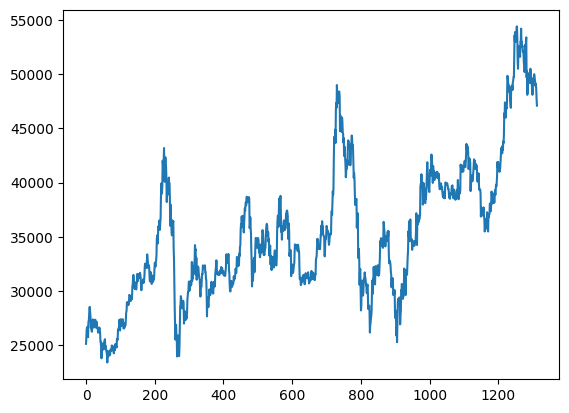

In [5]:
plt.plot(df1)

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. split the data into train and test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size 

train_data = df1[0:train_size,:]
test_data = df1[train_size:len(df1),:1]

In [8]:
#Training process
# a. convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# b. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [9]:
print(X_train)

[[0.05558335 0.07411113 0.098817   ... 0.12722519 0.11363922 0.11240296]
 [0.07411113 0.098817   0.10252255 ... 0.11363922 0.11240296 0.10252255]
 [0.098817   0.10252255 0.10622811 ... 0.11240296 0.10252255 0.12105034]
 ...
 [0.51440422 0.5029454  0.43419248 ... 0.44135827 0.47286196 0.47144171]
 [0.5029454  0.43419248 0.46140314 ... 0.47286196 0.47144171 0.45281709]
 [0.43419248 0.46140314 0.43561272 ... 0.47144171 0.45281709 0.44994432]]


In [10]:
# 8. Define GRU Model
model = xgb.XGBRegressor(
                        objective='reg:squarederror',
                        n_estimators=1000,
                        learning_rate=0.01,
                        max_depth=6,
                        subsample=0.8,
                        colsample_bytree=0.8)

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
# Dự báo dữ liệu test, val
y_pred=model.predict(X_test)

#  inverse transform the scaled ytest data back to its original scale.
y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [13]:
#Dự đoán 30 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output30 = []
n_steps = time_step
i = 0
pred_days = 30
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output30.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output30.extend(yhat.tolist())
        
        i = i+1
        

In [14]:
#Dự đoán 60 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output60 = []
n_steps = time_step
i = 0
pred_days = 60
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output60.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output60.extend(yhat.tolist())
        
        i = i+1

In [15]:
#Dự đoán 90 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output90 = []
n_steps = time_step
i = 0
pred_days = 90
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output90.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output90.extend(yhat.tolist())
        
        i = i+1
        

In [16]:
# Convert the prediction lists to NumPy arrays and reshape them
lst_output90 = np.array(lst_output90).reshape(-1, 1)
lst_output60 = np.array(lst_output60).reshape(-1, 1)
lst_output30 = np.array(lst_output30).reshape(-1, 1)

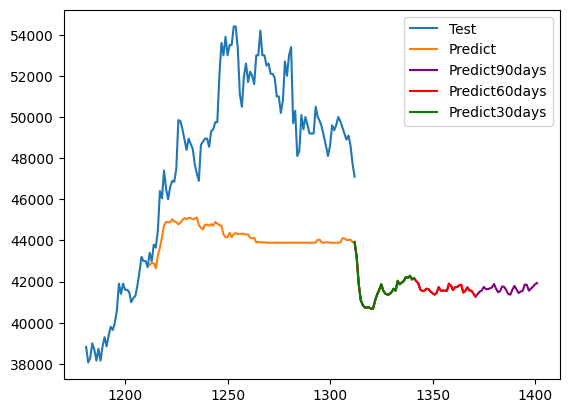

In [17]:


test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+time_step+1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))

predict_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output90), color='purple')
predict_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output60), color='red')
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output30), color='green')
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])

plt.show()

In [18]:
# 12. Đánh giá độ chính xác thuật toán 
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
print('Testing MAE:', test_mae)

from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Testing MAPE:', test_mape)  

Testing RMSE: 6153.499004359044
Testing MAE: 5571.479385829208
Testing MAPE: 0.10951812535928836
